In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Django', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"The Mines of the Behemoth, Shea",365.501681,7.459218,21.997076,49
Exchange Online and Defender,508.537323,13.039419,26.212009,39
Docker,529.679164,17.086425,29.382642,31
SSH + SCP,575.346085,19.839520,34.073107,29
GUI Docker Container,648.546192,30.883152,46.952965,21
Linux,1071.186574,33.474580,53.077611,32
"Everything is Tuberculosis, Green",781.686264,33.986359,55.338755,23
WinHex,775.800499,36.942881,52.682776,21
"The Simulacra, Dick",1005.801723,52.936933,73.560946,19
Windows PATH Variable,1666.857149,55.561905,115.279175,30


# Histogram

sum of ages: ~54662.45


<Axes: >

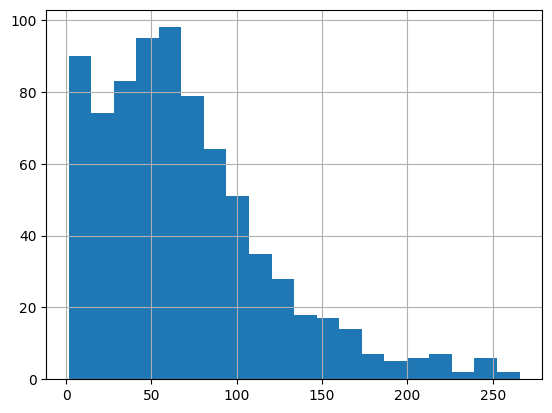

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54662.45


<Axes: >

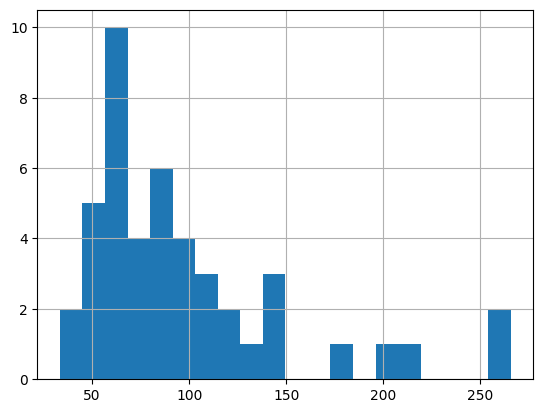

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Microsoft Purview']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 781
Total card age: 54662.45


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
8,Power BI,How does ALLEXCEPT work in a measure?\nALLEXCE...,547760950eb2cf2a75105d7c8cee95e3,-241.303831,-123.381661,241.303831,2220.869893,0.840158,18,0,0
9,Power BI,Q: What is the default command timeout for the...,1061ae75ffaa9959ed4d8cca3095a090,-199.811132,-123.381661,241.303831,2220.869893,0.840158,18,3,0
10,Power BI,Q: What role does Data Profiling in Power Quer...,6c1c0ba0ed6b90fb9ea8b49826740f4f,-134.927389,-123.381661,241.303831,2220.869893,0.840158,18,6,0
11,Power BI,Q: How do incremental refresh policies handle ...,79dd4081ee6b2c610e75c2810a6dca21,-105.596834,-123.381661,241.303831,2220.869893,0.840158,18,9,0
12,Power BI,What is the difference between row context and...,bec38d7eb236af37c59ab52a86e87bfb,-68.558847,-123.381661,241.303831,2220.869893,0.840158,18,12,0
13,Power BI,Q: What is the typical Power BI Service behavi...,120d9aff50885805a60b4845cc99a829,-49.404876,-123.381661,241.303831,2220.869893,0.840158,18,15,0
28,CCH Tax Forms Project,Pivot tables in Python (via libraries like pan...,eb5169802529468fde57f8dc2ceea41b,-228.388633,-114.997051,228.388633,2414.938075,0.002803,21,0,0
557,CCH Tax Forms Project,The concurrent.futures.ProcessPoolExecutor in ...,dfefada889a1d0a3a249490d25fe7194,-194.037535,-114.997051,228.388633,2414.938075,0.002803,21,3,0
30,CCH Tax Forms Project,Clearing elements with elem.clear() in Python’...,1bd7005ce0c8dd9b70e1d70d50dc7453,-134.975764,-114.997051,228.388633,2414.938075,0.002803,21,6,0
31,CCH Tax Forms Project,Restricting XML exports to identifiers and emp...,00395febe8e52556e832eda1025181f1,-104.087360,-114.997051,228.388633,2414.938075,0.002803,21,9,0


## Age Max

In [10]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(-1461.0922019597467)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
192,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,-265.686236,-96.926957,265.686236,4361.713079,0.495697,45,0,0
457,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,-256.700708,-96.926957,265.686236,4361.713079,0.495697,45,1,1
408,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,-250.937044,-110.126937,250.937044,3964.569741,0.561488,36,0,0
143,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,-250.500740,-110.126937,250.937044,3964.569741,0.561488,36,1,1
14,Python + Oauth2.0,authorize_url\n\nThe endpoint where the user i...,6a264f45c613880c60d7986e3d683448,-244.750236,-113.248976,244.750236,2151.730538,0.134468,19,0,0
263,Accounting,Amortization\nSystematic allocation of the cos...,414cb89a0e514694fbe4916816272b11,-241.985948,-91.287960,241.985948,730.303677,0.761994,8,0,0
8,Power BI,How does ALLEXCEPT work in a measure?\nALLEXCE...,547760950eb2cf2a75105d7c8cee95e3,-241.303831,-123.381661,241.303831,2220.869893,0.840158,18,0,0
57,"Mexican Gothic, Moreno-Garcia",traceries (TRAY-suh-reez)\nnoun\nDelicate orna...,3720f358b6a22134861965f53caa4c3e,-241.107710,-85.392053,241.107710,2390.977479,0.254615,28,0,0
284,Python + Oauth2.0,"(""localhost"", 8080)\n\nThe address tuple passe...",d33808d12096e5298b1e5c8617c745a4,-237.219468,-113.248976,244.750236,2151.730538,0.134468,19,1,1
28,CCH Tax Forms Project,Pivot tables in Python (via libraries like pan...,eb5169802529468fde57f8dc2ceea41b,-228.388633,-114.997051,228.388633,2414.938075,0.002803,21,0,0


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 69.990'